#Transfer learning with TensorFlow Part 3: Scaling up (food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101. (101 total classes of food)

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
#check to see if we are using a GPU
!pip install tensorflow==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Creating helper functions
In previous notebooks, we've created a series of helper functions to do different tasks, let's download them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-25 06:41:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-25 06:41:20 (113 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
#Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##101 Food classes: working with less data

our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-04-25 06:41:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  99.6MB/s    in 11s     

2023-04-25 06:41:35 (144 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
#how many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 imag

In [7]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False) #don't shuffle test_data for prediction analysis



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) functional efficientnetB0 backboned-model (we'll create our own output layer)
* Compile our model 
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [9]:
#Create data augmentation layer to incorporate it right into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1 is required for model like ResNet
], name = "data_augmentation")

In [10]:
#build an headless efficientnetb0 layer

#setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


#setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs, training = True) # augment images (only happens during training phase)
x = base_model(x, training = False) #put the base model in inference mode so weights which need to stay frozen stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
#get a summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
#compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])



In [13]:
#fit the model
initial_epochs = 5
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           steps_per_epoch = len(train_data_all_10_percent),
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 120s 442ms/step - loss: 3.3900 - accuracy: 0.2700 - val_loss: 2.7406 - val_accuracy: 0.3869
Epoch 2/5
237/237 [==============================] - 82s 346ms/step - loss: 2.2107 - accuracy: 0.4929 - val_loss: 2.2554 - val_accuracy: 0.4688
Epoch 3/5
237/237 [==============================] - 72s 303ms/step - loss: 1.8267 - accuracy: 0.5640 - val_loss: 2.0795 - val_accuracy: 0.4905
Epoch 4/5
237/237 [==============================] - 66s 276ms/step - loss: 1.6001 - accuracy: 0.6131 - val_loss: 2.0274 - val_accuracy: 0.4860
Epoch 5/5
237/237 [==============================] - 64s 269ms/step - loss: 1.4402 - accuracy: 0.6434 - val_loss: 1.9839 - val_accuracy: 0.4942


In [14]:
#evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 130s 165ms/step - loss: 1.7789 - accuracy: 0.5463


[1.7789496183395386, 0.5462574362754822]

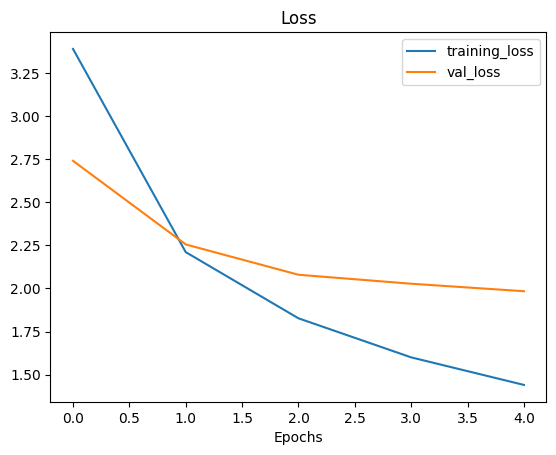

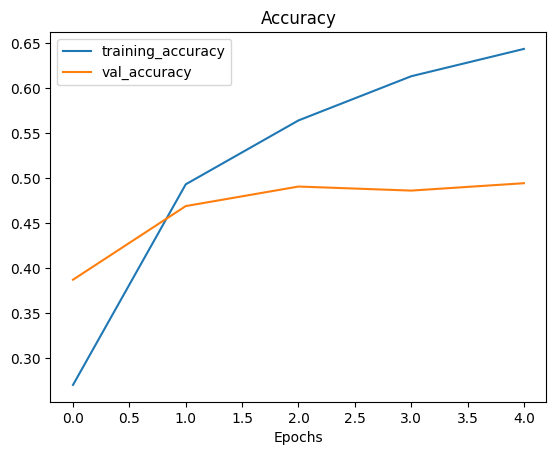

In [15]:
plot_loss_curves(history_all_classes_10_percent)

>**Question:** What do these curves suggest? Hint: ideally, the 2 curves should be very similar to each other, if not => overfitting (performing too well on the training data)

##Fine-tuning

In [16]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

#Refeeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
#Recompile the model with lower learning rate (it's typically the best practice to reduce the learning rate when fine-tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001), #learning rate lowered by 10x
              metrics = ["accuracy"])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
#what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [19]:
#check which layers are trainable in our base model 
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [20]:
#set up fine tune epochs
fine_tune_epochs = initial_epochs + 5 #model has already trained for 5 epochs (feature extraction), this is the total number of epochs we're after (5 more)

#fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     steps_per_epoch = len(train_data_all_10_percent),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1],
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)))


Epoch 5/10
237/237 [==============================] - 67s 249ms/step - loss: 1.2210 - accuracy: 0.6797 - val_loss: 1.9855 - val_accuracy: 0.4955
Epoch 6/10
237/237 [==============================] - 51s 214ms/step - loss: 1.1078 - accuracy: 0.6999 - val_loss: 1.9369 - val_accuracy: 0.5117
Epoch 7/10
237/237 [==============================] - 53s 222ms/step - loss: 1.0200 - accuracy: 0.7271 - val_loss: 1.8925 - val_accuracy: 0.5140
Epoch 8/10
237/237 [==============================] - 51s 211ms/step - loss: 0.9443 - accuracy: 0.7451 - val_loss: 1.9126 - val_accuracy: 0.5207
Epoch 9/10
237/237 [==============================] - 49s 203ms/step - loss: 0.8926 - accuracy: 0.7595 - val_loss: 1.8264 - val_accuracy: 0.5418
Epoch 10/10
237/237 [==============================] - 48s 200ms/step - loss: 0.8366 - accuracy: 0.7724 - val_loss: 1.8462 - val_accuracy: 0.5323


In [21]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 103s 130ms/step - loss: 1.6611 - accuracy: 0.5709


[1.6611440181732178, 0.5709307193756104]

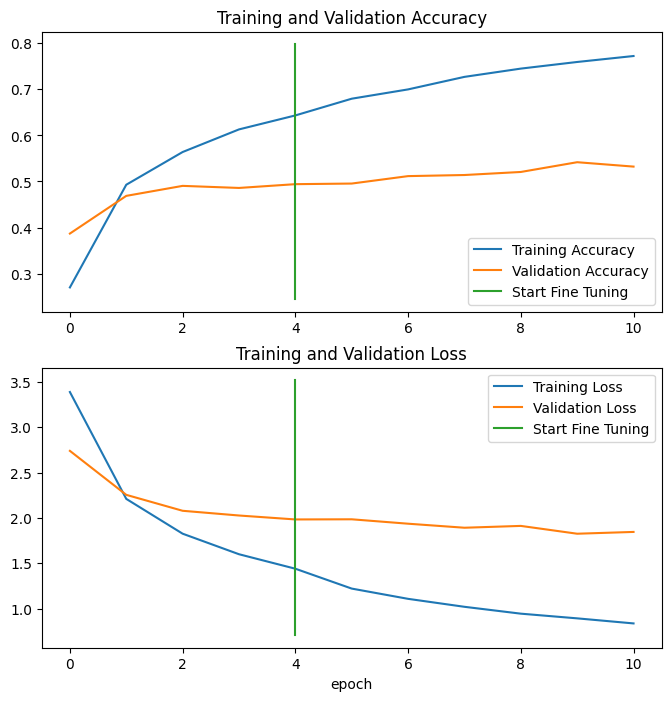

In [22]:
#Compare the history of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model

to use our model in an external application, we'll need to save it and export it somewhere

In [23]:
#save our fine-tune model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
#load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [25]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 106s 132ms/step - loss: 1.6612 - accuracy: 0.5716


[1.6612108945846558, 0.5716039538383484]

In [26]:
#the results from our loaded_model above should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.6611440181732178, 0.5709307193756104]

## Evaluating the performance of the big dog model across all different classes

let's make some predictions, visualize them and then later find out which predictions were the most "wrong"

In [27]:
import tensorflow as tf
#download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-04-25 07:02:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   112MB/s    in 0.4s    

2023-04-25 07:02:56 (112 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [29]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [30]:
#Evaluate loaded model (the one we jsut downloaded on test data)
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 64s 79ms/step - loss: 1.8027 - accuracy: 0.6078


In [31]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

##Making prediction with our trained model

In [34]:
# make predictions with model
preds_probs = model.predict(test_data, verbose = 1) #set verbosity to see how long is left

790/790 [==============================] - 68s 84ms/step


In [35]:
#how many predictions are there?
len(preds_probs)

25250

In [36]:
#What's the shape of our prediction
preds_probs.shape

(25250, 101)

In [37]:
#let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [39]:
#what does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.


In [40]:
#We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of predictions probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of predictions probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e

In [42]:
test_data.class_names[52]

'gyoza'

In [44]:
#Get the pred classes of each label
pred_classes = preds_probs.argmax(axis = 1)

#how do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [45]:
#how many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [49]:
#to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test labels look like: [0,0,0,0,1,0,0,0...,0], we want the index value where the "1" occurs

y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [50]:
# How many y_labels are there
len(y_labels)

25250

## Evaluating our model's predictions

one way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [51]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [52]:
#let's try sckitlearn accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [53]:
#does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

##Let's get visual: making a confusion matrix

In [55]:
from helper_functions import make_confusion_matrix


In [57]:
#get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [64]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ###changed (plot x-labels vertically)###
  plt.xticks(rotation=70, fontsize = text_size)
  plt.yticks(fontsize = text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [65]:
make_confusion_matrix(y_true=y_labels,
                      y_pred = pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size = 20,
                      savefig = True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class(e.g. percision, recall and F1) called classification_report, let's try out.

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand. 
How about we create a visualization to get a better understanding?

In [67]:
#Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores...

In [70]:
#Create empty dictionary
class_f1_scores = {}

#Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k=="accuracy": #stop once we get to accuracy key
    break
  else:
    #add class names and f1-score to a new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [72]:
#turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [77]:
f1_scores[-10:]

class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

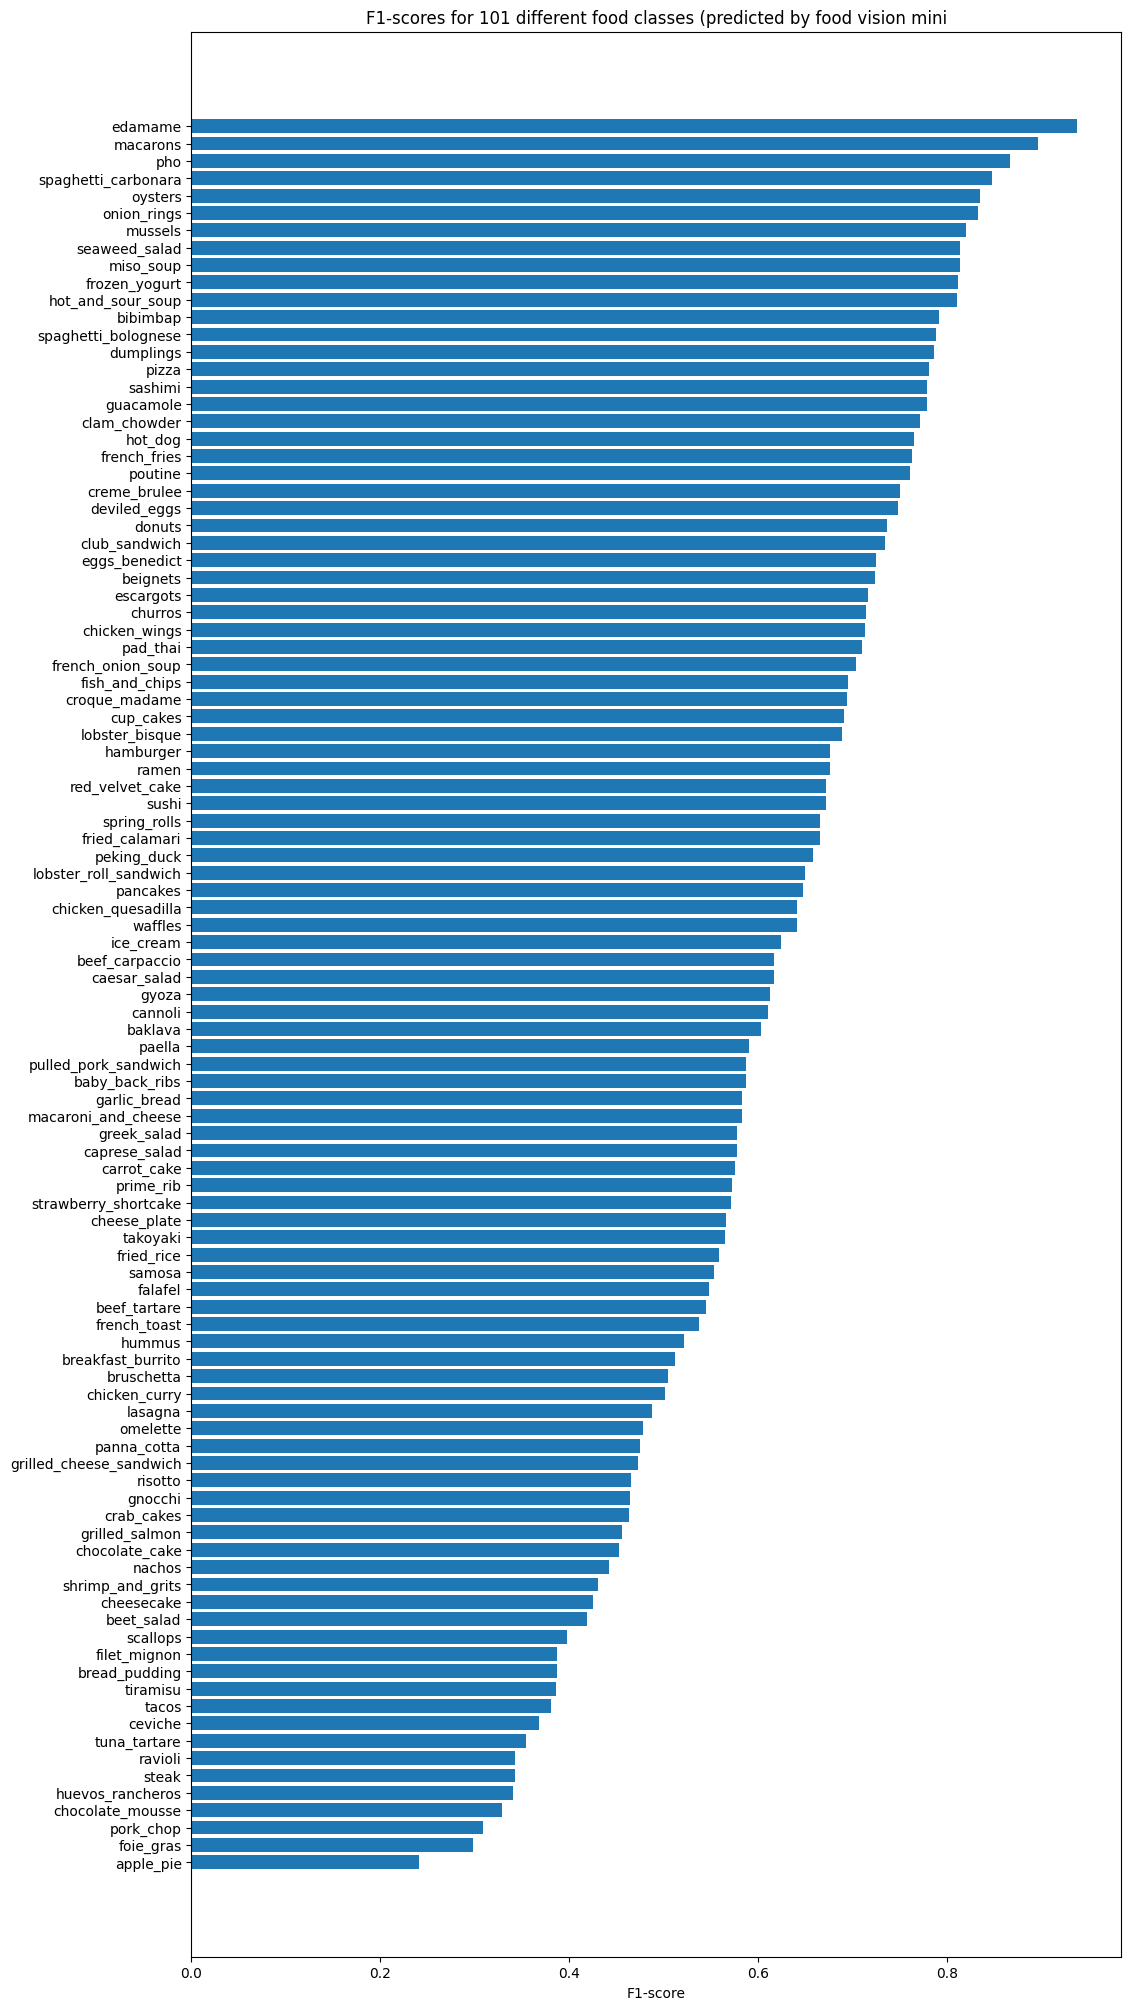

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values) #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes (predicted by food vision mini")
ax.invert_yaxis(); #reverse the order of our plot

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test data (images of our own, we'll see this later on)

To visualize our model's predictions on our own images, we'll need a function to load an preprocess images, specifically it will need to:
* read in a target filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
*Scale the image to  get all of the pixel values between 1 and 0 (if neccessary)

In [87]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape = 224, scale = True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specificied shape (img_shape, img_shape, color_channels = 3)
  

  Args:
    filename (str): path to target image
    image_shape (int): height/ width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not 
  
  Returns:
    Image tensor of shape (img_shape, img_shape, color_channels)
  """
  #read in the image
  img = tf.io.read_file(filename)

  #decode image into tensor
  img = tf.io.decode_image(img, channels = 3) #because png has 4 channels
  
  #resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale? yes/no
  if scale:
    #rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img #don't need to rescale images for EfficientNot models in TensorFlow

Now we've got a function to lead and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.


Specifically we'll write some code to:
1. load a few random images from the dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's prediction, prediction probability and truth label


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


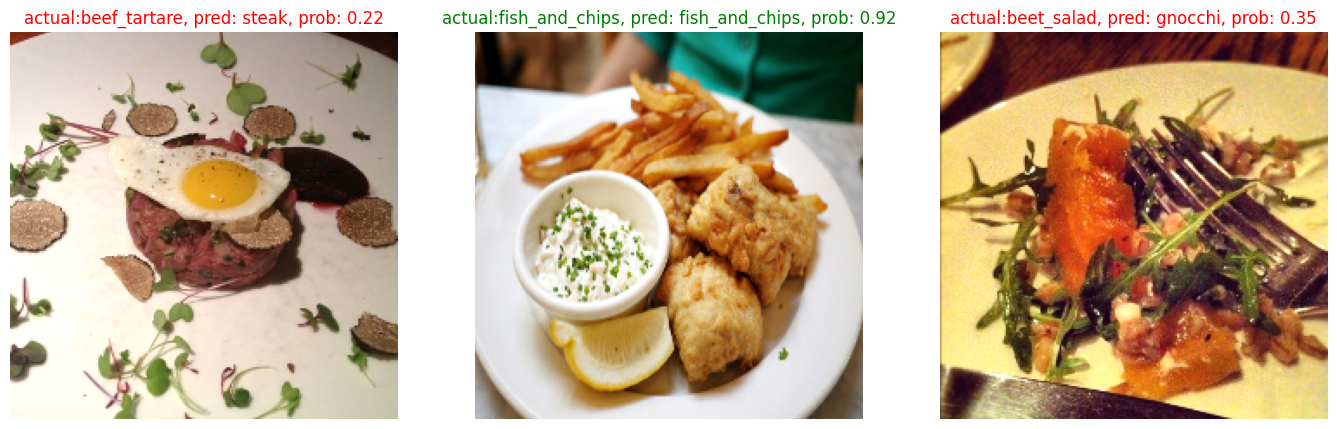

In [104]:
#make preds on a series of  random images
import os 
import random

plt.figure(figsize = (17,10))
for i in range(3):
  #choose a random image from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + class_name + "/" + filename
  # print(filepath)

  #load the image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis = 0)) #get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] #get highest prediction probabilities index
  # print(pred_class)

  #plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/225.)
  if class_name == pred_class:  #if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual:{class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color )
  plt.axis(False)

## Finding the most wrong predictions

To find out where our model is most wrong,let's write some code to find out the following:
1. Get all the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction  probability predictions at the top).
5. Visulize the image with the highest prediction probabilities but have wrong prediction


In [107]:
#get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]



[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [108]:
#2. create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis = 1),#get the maximum prediction probability values
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [109]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [111]:
#3. Find out in our DataFrame which predictios are wrong

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847418        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367901        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [134]:
#4. sort our DataFrame to have most wrong perdictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
...                                                  ...     ...     ...   
8763   b'/content/101_food_classes_10_percent/test/es...      35      41   
2663   b'/content/101_food_classes_10_percent/test/br...      10      61   
7924   b'/content/101_food_classes_10_percent/test/do...      31      29   
18586  b'/content/101_food_classes_10_percent/test/pe...      74      39   
3519   b'/content/101_food_classes_10_percent/test/ca...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996885            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

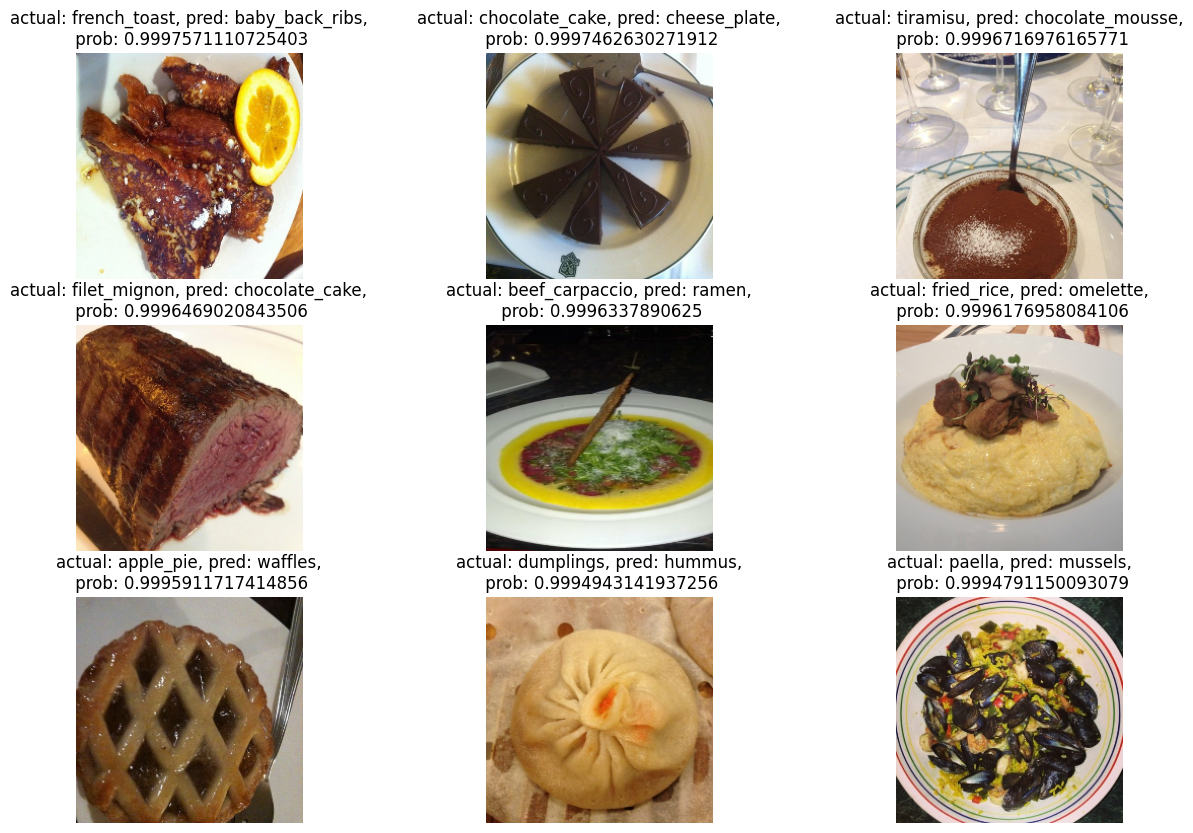

In [136]:
#5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:(start_index+images_to_view)].itertuples()):
  plt.subplot(3,3,i+1)
  
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname,_ = row #only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname},\n prob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [137]:
#Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2023-04-25 11:40:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2023-04-25 11:40:26 (89.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [139]:
#Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 42ms/step


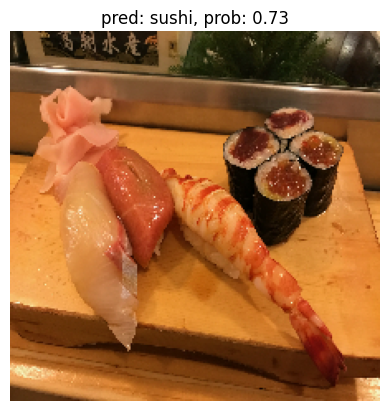

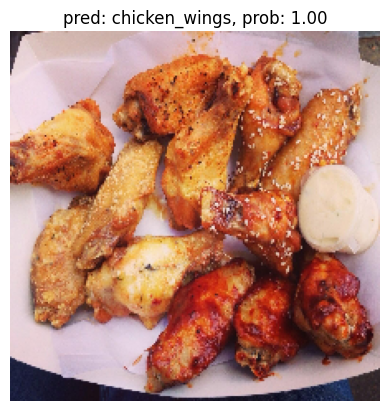

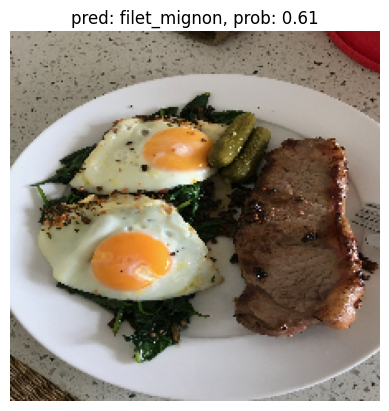

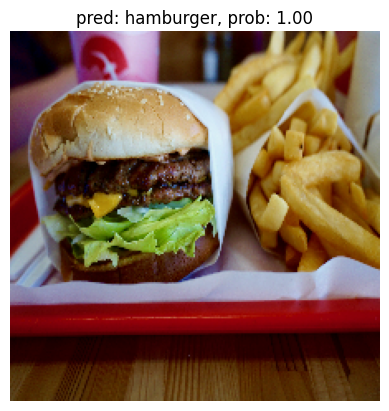

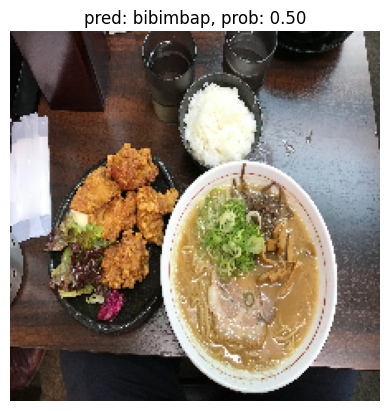

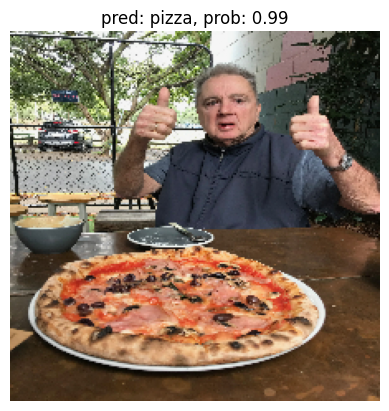

In [141]:
#make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False) #don't need to scale for our EfficientNetB0
  pred_prob = model.predict(tf.expand_dims(img, axis = 0)) #make prediction on image with shape [1, 224,224,3] (same shape with the model)
  pred_class = class_names[pred_prob.argmax()] #get the index with the highest prediction probability
  #plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)